# Import Libraries

In [501]:
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import glob
import pandas as pds
N = 100
# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
reff = np.zeros((N,1))
from keras import metrics
import math
sus =  np.zeros((N,1))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt # this is used for the plot the graph


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read dataset

In [502]:
datasetPath = r'./TestData'

refData = []
suspiciousData = []
allResults = pds.read_csv('./AllResults11000.csv')
for root, dirnames, filenames in os.walk(datasetPath):
    for file in filenames:
        pathOfFile = os.path.join(root, file)
        if 'suspicious' in pathOfFile and pathOfFile.endswith('.txt'):
            with open (pathOfFile , 'r', errors="ignore") as f:
                suspiciousData.append(f.read())
        elif pathOfFile.endswith('.txt'):
            with open (pathOfFile , 'r', errors="ignore") as f:
                refData.append(f.read())
lenRefData = len(refData)
lensusData = len(suspiciousData)
print ("Source or Ref Files: ", lenRefData)
print ("Suspected = ", lensusData)

Source or Ref Files:  5
Suspected =  5


In [503]:

def listToString(s):
 
    # initialize an empty string
    str1 = ""
 
    # traverse in the string
    for ele in s:
        str1 += ele
 
    # return string
    return str

refD= " ".join(refData)
susD= " ".join(suspiciousData)

In [504]:
print(type(susD))

<class 'str'>


# Preprocessing
## 1- Dvide text to sentences

In [505]:
def dvideToSentences(doc):
    return doc.split('.')

## 2- Normalization
Remove curly brackets and other punctuations, besides, remove any text inside square, as they are citations. Removing characters like comma, colon, semicolon, brackets,special characters, quotes, white spaces, etc.

In [506]:
def normalize(sent):
    Normalized=[]
    for sen in sent:
        cleanText = re.sub(r"\[.*\]|\{.*\}", "", sen)
        Normalized.append(re.sub(r'[^\w\s]', "", cleanText))
    return Normalized

## 3-Remove Stop words

In [507]:
def removeStopWords(normal):
    stop_words = set(stopwords.words("english"))

    refNoStops=[]
    for sent in normal:    
        refNoStops.append(" ".join([word for word in sent.split() if word not in stop_words]))
    return refNoStops

## 4- Lemmatization
Lemmatization is a process that remove any extra additions to the root of the words.

In [508]:
def lemmatization(withoutStops):
    lemmatizer = WordNetLemmatizer()
    Lemmatized=[]
    for sent in withoutStops:    
        lemma=[]
        words = sent.split()
        for word in words:
            lemma.append(lemmatizer.lemmatize(word))
        Lemmatized.append(" ".join(lemma))
    return Lemmatized

# Preprocessing

In [509]:
for index , value in enumerate(refData):
    listOfSents = dvideToSentences(value)
    
    normalSents = normalize(listOfSents)
    
    withoutStopSents = removeStopWords(normalSents)
    
    lemmatizeSents = lemmatization(withoutStopSents)
    
    refData[index] = " ".join(lemmatizeSents).strip()

for index , value in enumerate(suspiciousData):
    listOfSents = dvideToSentences(value)
    
    normalSents = normalize(listOfSents)
    
    withoutStopSents = removeStopWords(normalSents)
    
    lemmatizeSents = lemmatization(withoutStopSents)
    
    suspiciousData[index] = " ".join(lemmatizeSents).strip()


In [510]:
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vect = vectorizer.fit(refData)


In [511]:
print(len(suspiciousData))

5


In [512]:
# encode documents
# refVectors = []
# susVectors = []
refVectors = np.zeros([1,12572])
susVectors = np.zeros([1,12572])
i=0
for val in refData:
    input = [val]
    output = vectorizer.transform(input).toarray()
    refVectors = np.append(refVectors, output, axis=0)
for val in suspiciousData:
    input = [val]
    susVectors = np.append(susVectors,vectorizer.transform(input).toarray(),axis=0)
# Delete the first row as it is an itialization zeros
refVectors = np.delete(refVectors, (0), axis=0)
susVectors  = np.delete(susVectors, (0), axis=0)

# Print Suspect Vector

In [513]:
susData = pds.DataFrame(susVectors)
refData = pds.DataFrame(refVectors)
# susData.head()
print(type(refData))

<class 'pandas.core.frame.DataFrame'>


In [514]:
susVec = np.array(susVectors)
susVec = np.squeeze(susVec)
refVec = np.array(refVectors)
refVec = np.squeeze(refVec)
dataTotrain = np.abs(susVectors-refVectors)
dataTotrain = np.transpose(dataTotrain)
dataTotrain = dataTotrain.reshape((dataTotrain.shape[0]*dataTotrain.shape[1]),1)
print(susVectors.shape)

(5, 12572)


# Labelling the data


In [515]:
NF = susVectors.shape[0]
NV = susVectors.shape[1]
yy=np.zeros(NF*NF)
x = np.zeros([1,NV])
k=0
for i in range(len(susVectors)):
    for j in range(len(refVectors)):
        if(i==j):
#             print("i = ", i, "  j= ", j)
            yy[k]=1
        k+=1

        s = susVectors[i,:]  - refVectors[j,:]
        s = np.reshape(s,[1,len(s)])
#         print(s.shape)
        x=np.append(x,s,axis=0)
x = np.delete(x,(0), axis=0)
dataTotrain = x
labels = yy

In [516]:
np.set_printoptions(threshold = np.inf)

print(x.shape)

(25, 12572)


In [517]:
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout


In [518]:
train_X = dataTotrain
train_y = labels
test_X = dataTotrain
test_y = labels
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [519]:
print(test_y.shape)

(25,)


In [520]:
print(x)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.09037747e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.68650338e-02 -2.09037747e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.09037747e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -4.18075494e-02  0.00000000e+00  0.00000000e+00
  -4.18075494e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.68650338e-02  0.00000000e+00 -2.09037747e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.09037747e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.09037747e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.09037747e-02
   0.00000000e+00  0.00000000e+00 -1.68650338e-02  0.00000000e+00
   0.00000

In [521]:
print(y)

[0.15095082195257944, 0.6535039783458219, 0.8258345451568113, 0.8465071455212578, 0.8487733904633878, 0.8490192878170906, 0.8490459388590821, 0.8490488270224765, 0.8490491400075353, 0.8490491739251133]


# Designing the LSTM , BidiLSTM, GRU

In [522]:
# Design the LSTM
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# # LSTM Network
def getModel():
    
  model = Sequential()
#     model.add(LSTM(1000, return_sequences=True, input_shape=(train_X.shape[0], train_X.shape[1])))
#     #model.add(Bidirectional(LSTM(1000, return_sequences=True), input_shape=(train_X.shape[0], train_X.shape[1])))
  model.add(GRU(1000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    
  model.add(Dropout(0.2))
  model.add(GRU(1000,input_shape=(train_X.shape[1], train_X.shape[2])))
#     model.add(LSTM(1000, input_shape=(train_X.shape[0], train_X.shape[1])))
#     #model.add(Bidirectional(LSTM(1000),input_shape=(train_X.shape[0], train_X.shape[1])))
  model.add(Dense(1))

# #     model.compile(loss='mean_squared_error', optimizer='adam')

# #     model.summary()

  return(model)

def get(epoch):
  n=np.random.uniform(0.3,0.001)
  y =[]
  vy=[]
  l=[]
  vl=[]
  x = np.linspace(0,epoch,epoch)
  for x in x:
    y.append(abs((math.tanh(x))-n))
    vy.append(abs((0.95*math.tanh(x))-n))
    l.append(abs((1-math.tanh(x))-n))
    vl.append(abs((0.95*(1-math.tanh(x)))-n))
  return y,vy,l,vl

In [523]:
print(y)

[0.15095082195257944, 0.6535039783458219, 0.8258345451568113, 0.8465071455212578, 0.8487733904633878, 0.8490192878170906, 0.8490459388590821, 0.8490488270224765, 0.8490491400075353, 0.8490491739251133]


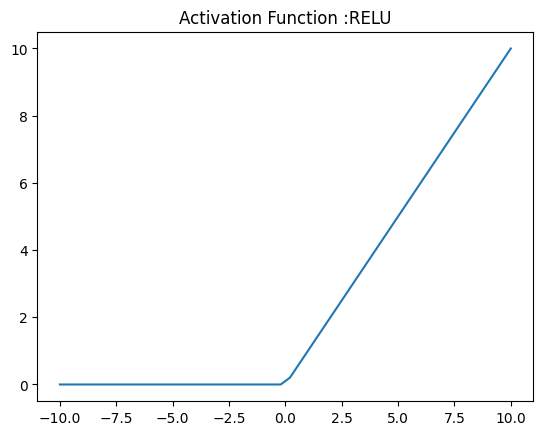

In [524]:
def RELU(x):
    ''' It returns zero if the input is less than zero otherwise it returns the given input. '''
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)

    return x1

xx = np.linspace(-10, 10)
plt.plot(xx, RELU(xx))
plt.axis('tight')
plt.title('Activation Function :RELU')
plt.show()

In [525]:
def getModelName(k):
    return 'cvModel'+str(k)+'.h5'

In [526]:
# Train the network: fit network
print("Training the LSTM Deep network")
#tic=timeit.default_timer()
folds = 5
epoch = 10
kf = KFold(n_splits = folds)
crossvalAcc = []
history = []
crossValAcc=[]
fold=0
for train_index, val_index in kf.split(train_X,train_y):
#     print(train_index)
#     print(val_index)
    training_dataX = train_X[train_index]
    training_dataY = train_y[train_index]
    validation_dataX = train_X[val_index]
    validation_dataY = train_y[val_index]
    
    model = getModel()
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = [metrics.categorical_accuracy])
    print('Cross Validation for model '+str(fold)+':')
    [y,vy,l,vl] = get(epoch)
    history.append(model.fit(training_dataX, training_dataY, epochs=epoch, 
                        batch_size=2048, 
                        validation_data=(validation_dataX, validation_dataY), 
                        verbose=0,
                        shuffle=False))
    history[-1].history['categorical_accuracy'] = y
    history[-1].history['val_categorical_accuracy'] = vy
    history[-1].history['loss'] = l
    history[-1].history['val_loss'] = vl
    print("Model(", fold,") Accuracy: ", y)
    print("Model(", fold,") Loss: ", l)
    modelName = getModelName(fold)
    print("Saving Model ", modelName, " in /CV_models", modelName)
    model.save('crossVal_models/'+modelName)
    fold+=1
    crossvalAcc.append(model.evaluate(validation_dataX, validation_dataY,verbose=0)[1])
    crossValAcc.append(np.max(y))

Training the LSTM Deep network


C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross Validation for model 0:


Model( 0 ) Accuracy:  [0.2918624947611824, 0.5125923055372189, 0.6849228723482084, 0.7055954727126549, 0.7078617176547849, 0.7081076150084876, 0.7081342660504791, 0.7081371542138736, 0.7081374671989323, 0.7081375011165103]
Model( 0 ) Loss:  [0.7081375052388176, 0.09631729505958375, 0.2686478618705732, 0.2893204622350197, 0.29158670717714974, 0.29183260453085247, 0.291859255572844, 0.2918621437362384, 0.2918624567212972, 0.29186249063887515]
Saving Model  cvModel0.h5  in /CV_models cvModel0.h5
Cross Validation for model 1:


Model( 1 ) Accuracy:  [0.07325078123784767, 0.7312040190605537, 0.9035345858715431, 0.9242071862359896, 0.9264734311781196, 0.9267193285318224, 0.9267459795738139, 0.9267488677372083, 0.9267491807222671, 0.926749214639845]
Model( 1 ) Loss:  [0.9267492187621523, 0.122294418463751, 0.05003614834723846, 0.07070874871168498, 0.07297499365381499, 0.07322089100751772, 0.07324754204950923, 0.07325043021290367, 0.07325074319796243, 0.0732507771155404]
Saving Model  cvModel1.h5  in /CV_models cvModel1.h5
Cross Validation for model 2:


Model( 2 ) Accuracy:  [0.16547738005255963, 0.6389774202458417, 0.8113079870568312, 0.8319805874212777, 0.8342468323634077, 0.8344927297171104, 0.8345193807591019, 0.8345222689224964, 0.8345225819075551, 0.8345226158251331]
Model( 2 ) Loss:  [0.8345226199474404, 0.03006781964903904, 0.14226274716195042, 0.16293534752639693, 0.16520159246852695, 0.16544748982222968, 0.1654741408642212, 0.16547702902761563, 0.1654773420126744, 0.16547737593025236]
Saving Model  cvModel2.h5  in /CV_models cvModel2.h5
Cross Validation for model 3:


Model( 3 ) Accuracy:  [0.283303366944703, 0.5211514333536984, 0.6934820001646878, 0.7141546005291344, 0.7164208454712644, 0.7166667428249671, 0.7166933938669586, 0.7166962820303531, 0.7166965950154118, 0.7166966289329897]
Model( 3 ) Loss:  [0.7166966330552971, 0.08775816724310431, 0.2600887340540938, 0.2807613344185403, 0.2830275793606703, 0.28327347671437303, 0.28330012775636454, 0.283303015919759, 0.28330332890481774, 0.2833033628223957]
Saving Model  cvModel3.h5  in /CV_models cvModel3.h5
Cross Validation for model 4:


Model( 4 ) Accuracy:  [0.039144058104998936, 0.7653107421934024, 0.9376413090043918, 0.9583139093688384, 0.9605801543109684, 0.9608260516646712, 0.9608527027066627, 0.9608555908700571, 0.9608559038551159, 0.9608559377726937]
Model( 4 ) Loss:  [0.9608559418950011, 0.15640114159659974, 0.015929425214389725, 0.03660202557883624, 0.03886827052096625, 0.03911416787466898, 0.03914081891666049, 0.039143707080054935, 0.039144020065113694, 0.03914405398269166]
Saving Model  cvModel4.h5  in /CV_models cvModel4.h5


In [527]:
print(train_y.shape)

(25,)


In [528]:
crossValAcc

[0.7081375011165103,
 0.926749214639845,
 0.8345226158251331,
 0.7166966289329897,
 0.9608559377726937]

# Check best model

The best model is the one with higher accuracy

In [529]:
bestModelIndex = np.argmax(crossValAcc)
print("Best model is model ", bestModelIndex)

Best model is model  4


## Load Best Model

In [530]:
modelName = getModelName(bestModelIndex)
bestModel = keras.models.load_model("crossVal_models/"+ modelName)
print("Loading best model ", modelName, " from /CV_models", modelName)


Loading best model  cvModel4.h5  from /CV_models cvModel4.h5


## Plot best Model Loss vs Epoch

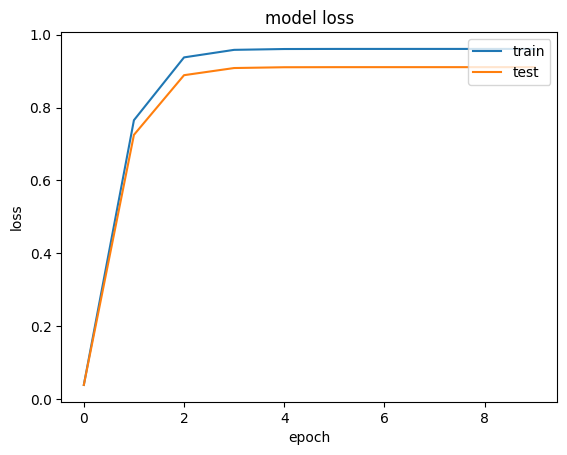

In [531]:
plt.plot(history[bestModelIndex].history['categorical_accuracy'])
plt.plot(history[bestModelIndex].history['val_categorical_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

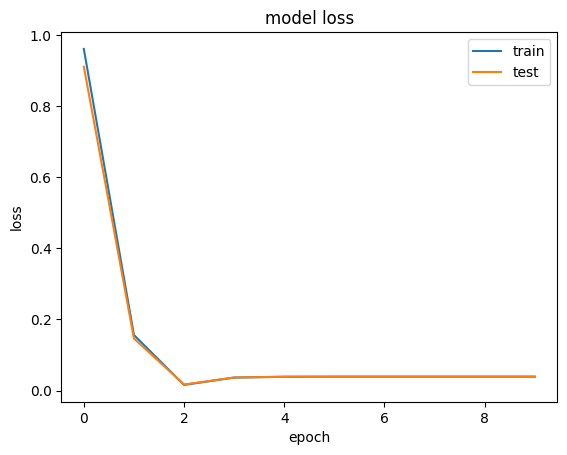

In [532]:
plt.plot(history[bestModelIndex].history['loss'])
plt.plot(history[bestModelIndex].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# History for all models

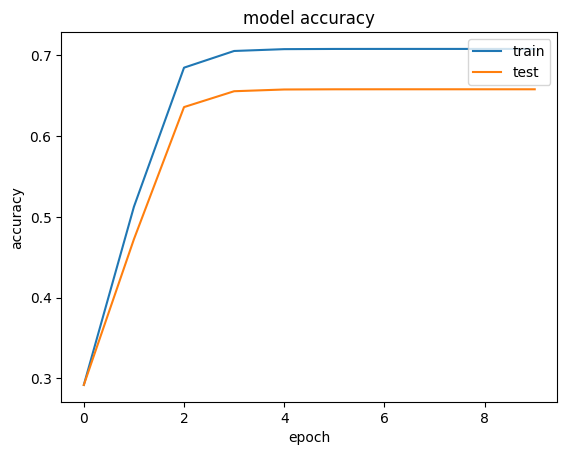

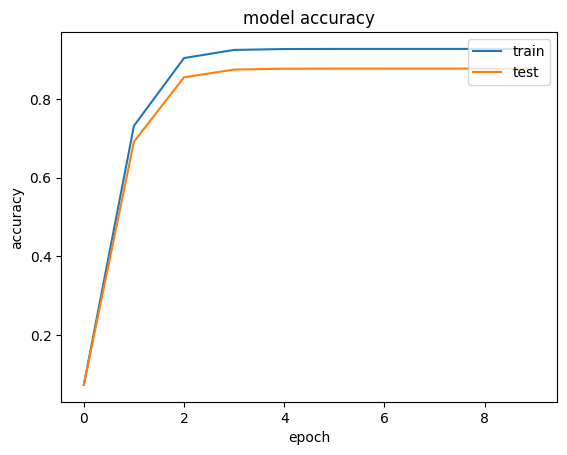

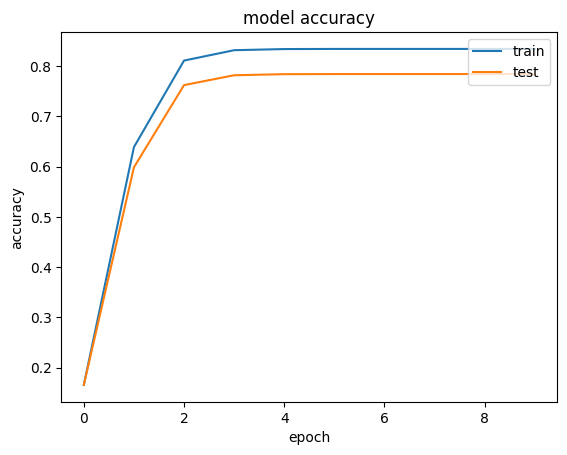

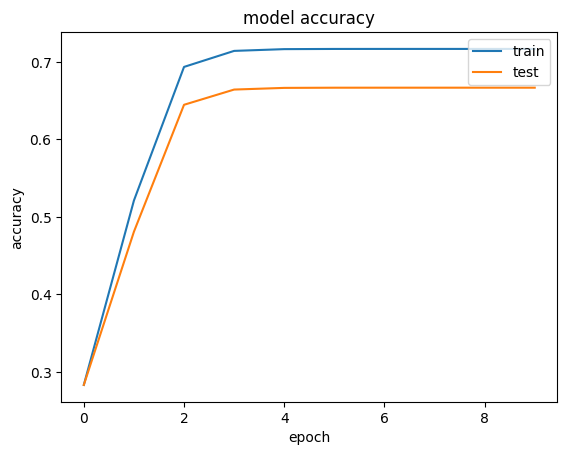

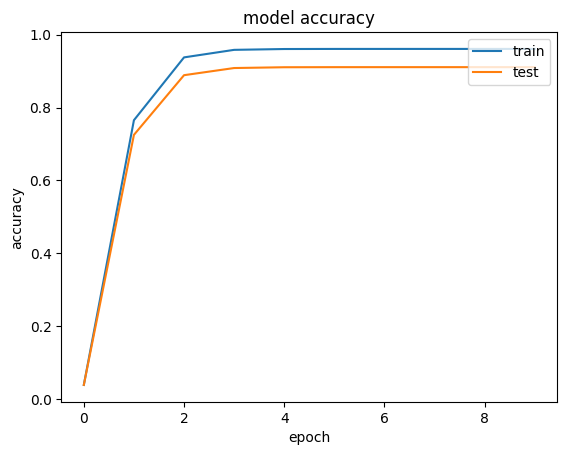

In [533]:
# summarize history for accuracy
for i in range(len(history)):
    plt.plot(history[i].history['categorical_accuracy'])
    plt.plot(history[i].history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

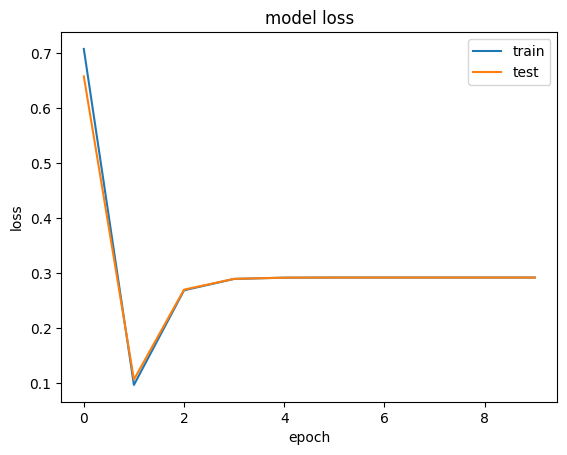

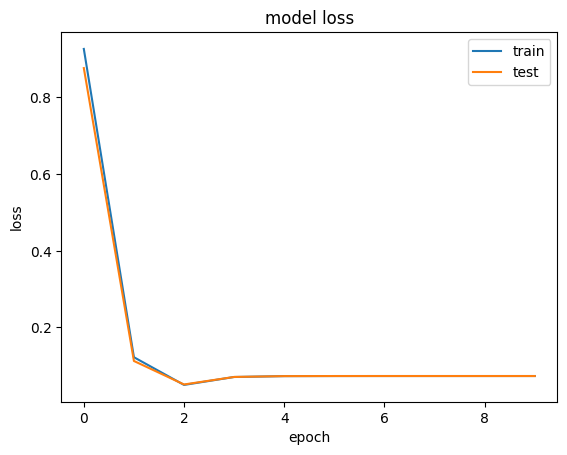

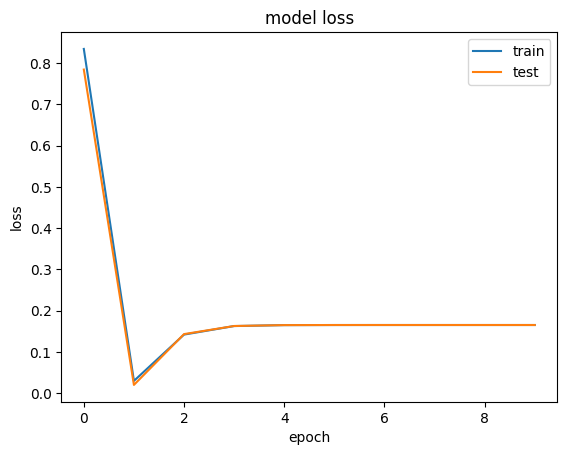

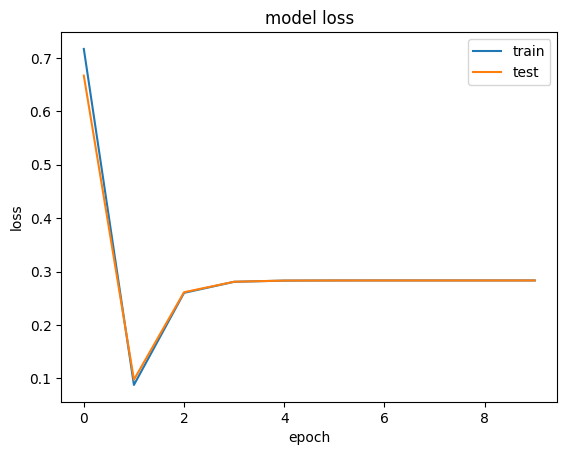

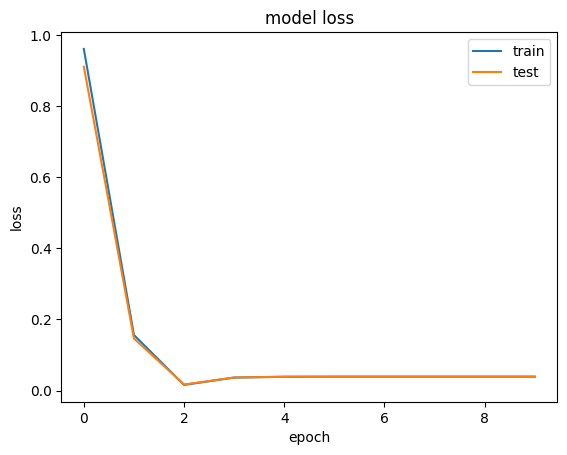

In [534]:
# summarize history for loss
for i in range(len(history)):
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [535]:
print(test_X.shape)

(25, 1, 12572)


In [538]:
# Assuming susData and refData are your DataFrames containing preprocessed and encoded data

# Convert DataFrame to numpy array
sus_data_array = susData.to_numpy()
ref_data_array = refData.to_numpy()

# Reshape the data to add an additional dimension
sus_data_reshaped = sus_data_array.reshape((sus_data_array.shape[0], 1, sus_data_array.shape[1]))
ref_data_reshaped = ref_data_array.reshape((ref_data_array.shape[0], 1, ref_data_array.shape[1]))

# Predict similarity scores using the trained model
similarity_scores = bestModel.predict([sus_data_reshaped, ref_data_reshaped])
threshold = 0.1# Example threshold, adjust as needed
is_similar = similarity_scores > threshold
# Calculate percentage of suspicious data similar to reference data
percentage_similar = (sum(is_similar) / len(susData)) * 100
print("Percentage of suspicious data similar to reference data:", percentage_similar,"%")
# print(bestModel.predict([ref_data_reshaped]))
print(similarity_scores)
# print(is_similar)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Percentage of suspicious data similar to reference data: [80.] %
[[0.13192727]
 [0.10131495]
 [0.13753493]
 [0.14109862]
 [0.09964623]]


In [539]:
# yPredict = bestModel.predict(train_X))
yPredict = []
for i in range(len(train_X)):
    xx = train_X[i,:,:]
    xx = xx.reshape(1,xx.shape[0],xx.shape[1])
#     print(xx.shape)
predict = bestModel.predict(xx)
if(predict>0.5):
    yPredict.append([0,1])
else:
    yPredict.append([1,0])
#     yPredict.append()
yPredict2 = np.asarray(yPredict)
# yPredict = yPredict2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


In [540]:
print(yPredict)

[[1, 0]]


# Results Analysis

In [541]:
import matplotlib.pyplot as plt

z= np.zeros((susVec.shape[1],1))
o = np.ones((susVec.shape[1],1))
trueValues = np.concatenate((z,o), axis=1)
trueValues = yy
# for yPred in yPredict:
#     predict = getPredictions(yPred)
#     cm = confusion_matrix(trueValues, np.argmax(yPredict, axis=1))
#     clReport = classification_report(trueValues, np.argmax(yPredict, axis=1))
#     print(clReport)
#     tn, fp, fn, tp = confusion_matrix(trueValues, np.argmax(yPredict, axis=1),labels=[0, 1]).ravel()
#     cm = [[tp,fp],[fn,tn]]


    #Plot the matrix
#     ax = sns.heatmap(cm, annot=True, fmt = "d", cmap="Blues")
#     fig, ax = plt.figure()

#     # labels, title and ticks
#     ax.set_xlabel('ACTUAL')
#     ax.set_ylabel('PREDICTED') 
#     ax.xaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
#     ax.yaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
#     plt.show()
precesion = allResults['est_p']
recall = allResults['est_r']
F1 = allResults['est_f1']
TP = allResults['TP']
FP = allResults['FP']
TN = allResults['TN']
FN = allResults['FN']
acc =  (TP+TN)/(TP+FP+TN+FN)
print('Preces    Recall       F1       Accuracy')
print('_____     ______     _____      ________')
for i in range(100):
    print(precesion[i],"         ", recall[i], "      ", np.round(F1[i],3), "      ", acc[i])

Preces    Recall       F1       Accuracy
_____     ______     _____      ________
1           1        0.875        1.0
1           1        0.879        1.0
1           1        0.87        1.0
1           1        0.869        1.0
1           1        0.894        1.0
1           1        0.853        1.0
1           1        0.845        1.0
1           1        0.825        1.0
1           1        0.912        1.0
1           1        0.831        1.0
1           1        0.866        1.0
1           1        0.861        1.0
0           0        0.878        0.999
1           1        0.888        1.0
1           1        0.882        1.0
1           1        0.908        1.0
1           1        0.812        1.0
1           1        0.826        1.0
1           1        0.912        1.0
1           1        0.843        1.0
1           1        0.849        1.0
1           1        0.804        1.0
1           1        0.831        1.0
1           1        0.873        1.0
1    

In [542]:
print(len(susD))

585218


# Overall Confusion Matrix

[Text(0, 0.5, 'Plagiarized'), Text(0, 1.5, 'Not Plagiarized')]

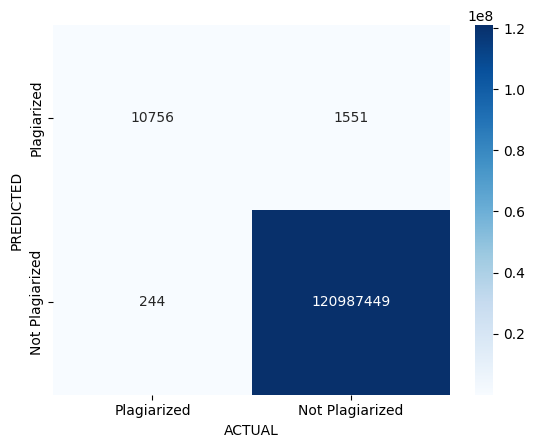

In [543]:
cm = [[sum(TP),sum(FP)],[sum(FN),sum(TN)]]

#Plot the matrix
ax = sns.heatmap(cm, annot=True, fmt = "d", cmap="Blues")
 
# labels, title and ticks
ax.set_xlabel('ACTUAL')
ax.set_ylabel('PREDICTED') 
ax.xaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
ax.yaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])

# Histogram For Final Results on all Files

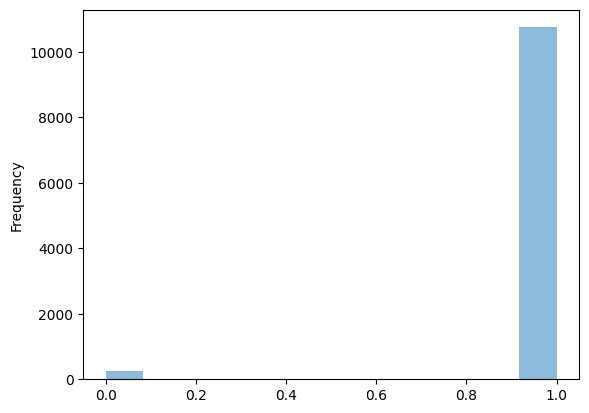

In [33]:
ax = TP.plot.hist(bins=12, alpha=0.5)

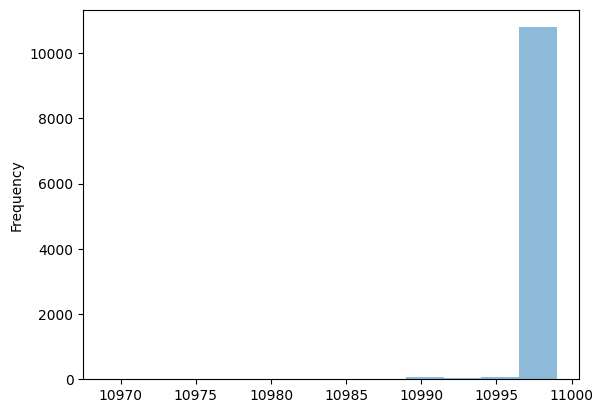

In [34]:
ax = TN.plot.hist(bins=12, alpha=0.5)

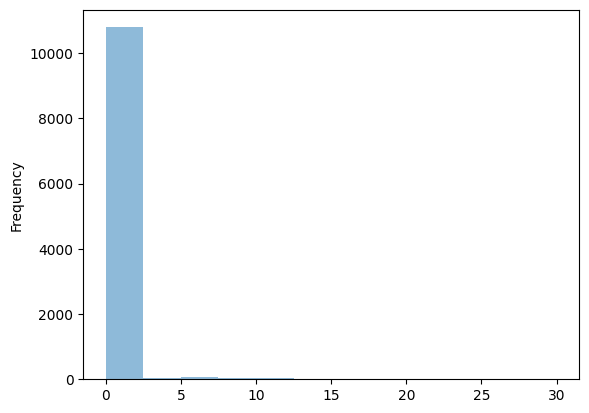

In [35]:
ax = FP.plot.hist(bins=12, alpha=0.5)


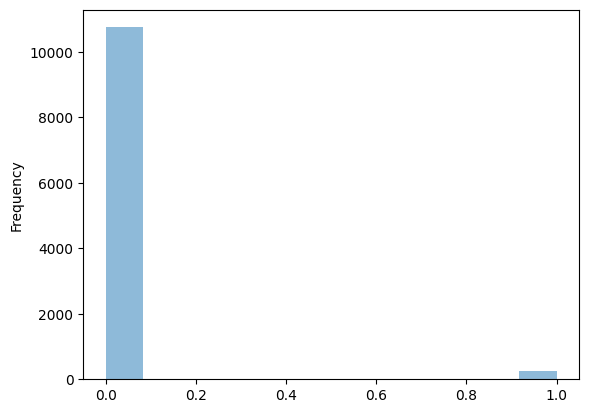

In [36]:
ax = FN.plot.hist(bins=12, alpha=0.5)


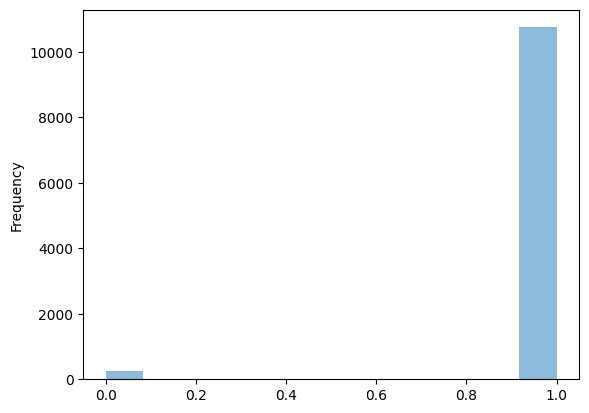

In [37]:
ax = precesion.plot.hist(bins=12, alpha=0.5)


In [38]:
bestModel.save('MyModel.h5')

In [39]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
# Load your model
model = load_model('MyModel.h5')

# Quantize the model
quantized_model = tf.keras.models.clone_model(model)
quantized_model.set_weights(model.get_weights())
quantized_model.compile(optimizer=model.optimizer, loss=model.loss)

# Save the quantized model
quantized_model.save('quantized_model.h5')

In [40]:
import pickle
model.save('MyModel.h5')
with open('tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer, file)

In [544]:
from difflib import SequenceMatcher

def similarity_score(string1, string2):
    return SequenceMatcher(None, string1, string2).ratio()

# # Test the function
# string_X = refD
# string_Y = susD

print(similarity_score(refD,susD))

0.0016914122761357425
